# Simulating classification using partial feature matches

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pyrepseq as prs
import pandas as pd
import random
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")
aminoacids = 'ACDEFGHIKLMNPQRSTVWY'

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

Matplotlib is building the font cache; this may take a moment.
/Users/james/Documents/Projects/TCR-info 2022/paper_tcrinfo/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulating a background 

In [2]:
def generate_background(k, n_seqs):
    
    generated_seqs = []
    for i in range(n_seqs):
        
         generated_seqs.append(''.join(random.choice(aminoacids) for i in range(k)))
            
    return generated_seqs

### Creating alpha and beta chains using binding rules

In [3]:
def list_motif(*motif):
    return list(''.join(seq) for seq in itertools.product(*motif))

In [4]:
def simulate_binding(df_back, k, c, num_seqlogos, prng=np.random):
    specific_sequences = []
    for i in range(num_seqlogos):
        motif = [tuple(prng.choice(list(set(aminoacids)), size=c, replace=False))
                 for i in range(k)]
        specific_sequences.extend(list_motif(*motif))
        
    sampled_sequences = np.array(df_back['aa_sequence'][df_back['aa_sequence'].isin(set(specific_sequences))])
    return sampled_sequences

### Simulate background and specific set generation

In [5]:
prng = np.random.RandomState(12345)
# number of total sites
k = 4
# number of choices for specific binding
c = 3

In [6]:
background = generate_background(k, int(1e7))
df_back = pd.DataFrame({"aa_sequence" : background})
df_back['origin'] = 'background'
df_back["Alpha"] = df_back["aa_sequence"].apply(lambda x: x[:k//2])
df_back["Beta"] = df_back["aa_sequence"].apply(lambda x: x[k//2:])
df_back["VA"] = df_back["Alpha"].apply(lambda x: x[0])

In [7]:
specific_sequences = simulate_binding(df_back, k, c, 5, prng=np.random)
df_spc = pd.DataFrame({"aa_sequence" : specific_sequences})
df_spc['origin'] = 'specific'
df_spc["Alpha"] = df_spc["aa_sequence"].apply(lambda x: x[:k//2])
df_spc["Beta"] = df_spc["aa_sequence"].apply(lambda x: x[k//2:])
df_spc["VA"] = df_spc["Alpha"].apply(lambda x: x[0])

### Compute epitope specific information contained within simulated features

In [8]:
info_full = prs.renyi2_entropy(df_back, 'aa_sequence') - prs.renyi2_entropy(df_spc, 'aa_sequence')
info_half = prs.renyi2_entropy(df_back, 'Alpha') - prs.renyi2_entropy(df_spc, 'Alpha')
info_independent = prs.renyi2_entropy(df_back, 'Alpha') - prs.renyi2_entropy(df_spc, 'Alpha') + prs.renyi2_entropy(df_back, 'Beta') - prs.renyi2_entropy(df_spc, 'Beta')
info_residue = prs.renyi2_entropy(df_back, 'VA') - prs.renyi2_entropy(df_spc, 'VA')

### Simulate spiking in specific sequences into a background repertoire

In [9]:
SET_SIZE = 1e6
frac_list = np.logspace(-6, 0, 50)
p_correct_full = []
p_correct_half = []
p_correct_independent = []
p_correct_residue = []
for frac_spc in frac_list:
    mixed_df = pd.concat([df_spc.sample(int(SET_SIZE*frac_spc), replace=True), df_back.sample(int(SET_SIZE*(1-frac_spc)), replace=True)])
    p_correct_full.append(mixed_df[mixed_df['aa_sequence'].isin(df_spc['aa_sequence'])]['origin'].value_counts(normalize=True)['specific'])
    p_correct_half.append(mixed_df[mixed_df['Alpha'].isin(df_spc['Alpha'])]['origin'].value_counts(normalize=True)['specific'])
    p_correct_independent.append(mixed_df[mixed_df['Alpha'].isin(df_spc['Alpha']) & mixed_df['Beta'].isin(df_spc['Beta'])]['origin'].value_counts(normalize=True)['specific'])
    p_correct_residue.append(mixed_df[mixed_df['VA'].isin(df_spc['VA'])]['origin'].value_counts(normalize=True)['specific'])
    
p_correct_full = np.array(p_correct_full)
p_correct_half = np.array(p_correct_half)
p_correct_independent = np.array(p_correct_independent)
p_correct_residue = np.array(p_correct_residue)

In [10]:
FONT_SIZE = 18

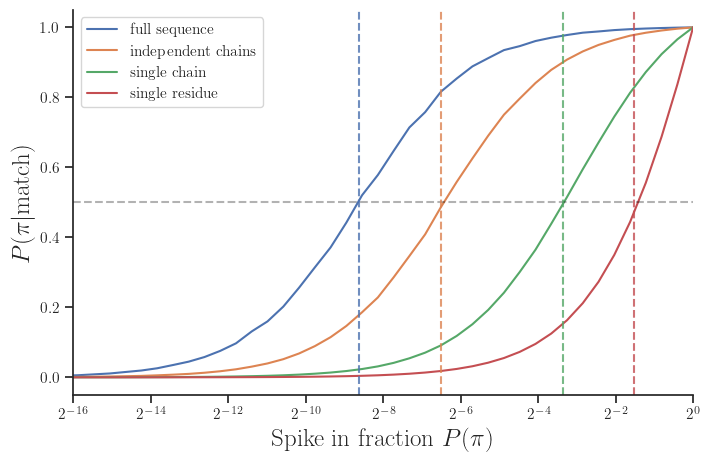

In [11]:
plt.figure(figsize = (8, 5))
plt.plot(frac_list, p_correct_full, label='full sequence')
plt.plot(frac_list, p_correct_independent, label='independent chains')
plt.plot(frac_list, p_correct_half, label='single chain')
plt.plot(frac_list, p_correct_residue, label='single residue')

plt.axhline(0.5, alpha=0.3, c='black', linestyle='--')
plt.axvline(2**(-info_full)/(1+2**(-info_full)), alpha=0.8, linestyle='--', c=sns.color_palette()[0])
plt.axvline(2**(-info_independent)/(1+2**(-info_independent)), alpha=0.8, linestyle='--', c=sns.color_palette()[1])
plt.axvline(2**(-info_half)/(1+2**(-info_half)), alpha=0.8, linestyle='--', c=sns.color_palette()[2])
plt.axvline(2**(-info_residue)/(1+2**(-info_residue)), alpha=0.8, linestyle='--', c=sns.color_palette()[3])

plt.xscale('log', base=2)
plt.legend()
plt.xlim([2**(-16), 1])
plt.xlabel("Spike in fraction $P(\pi)$", fontsize=FONT_SIZE)
plt.ylabel("$P(\pi | \mathrm{match})$", fontsize=FONT_SIZE)
plt.savefig('figures/figureS1.svg',bbox_inches='tight', dpi=500);